In [13]:
import warnings
warnings.filterwarnings('ignore')

from io import StringIO
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.figure_factory as ff
import plotly

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    display.precision = 15  # set as needed
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

set_pandas_display_options()

### Train and Test Data Loading and Viewing

In [6]:
trainDf = pd.read_csv('train.csv')
trainDf.replace("nan", np.nan, inplace=True)
trainDf.dropna(how = 'all')

testDf = pd.read_csv('test.csv')
testDf.replace("nan", np.nan, inplace=True)
testDf.dropna(how = 'all')

# Changing the names of the column - replacing whitespace with underscore(_)
trainDf.columns = ['_'.join(col.split(' ')) for col in trainDf.columns]
testDf.columns = ['_'.join(col.split(' ')) for col in testDf.columns]

target_feat = 'Credit_Default'

print(f"\nTrain Data Size : {trainDf.shape}")
print(f"Test Data Size : {testDf.shape}")

print(f"\n\n:: Train Data Sample ::")
display(trainDf.head())

print(f"\n\n:: Transposed Train Data ::")
display(trainDf.T)

print(f"\n\n:: Transposed Test Data ::")
display(testDf.T)


Train Data Size : (7500, 18)
Test Data Size : (2500, 17)


:: Train Data Sample ::


Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0   0       Own Home       482087.0                  NaN        0.0   
1   1       Own Home      1025487.0            10+ years        0.0   
2   2  Home Mortgage       751412.0              8 years        0.0   
3   3       Own Home       805068.0              6 years        0.0   
4   4           Rent       776264.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0



:: Transposed Train Data ::


0                   1     \
Id                                             0                   1   
Home_Ownership                          Own Home            Own Home   
Annual_Income                             482087             1025487   
Years_in_current_job                         NaN           10+ years   
Tax_Liens                                      0                   0   
Number_of_Open_Accounts                       11                  15   
Years_of_Credit_History                     26.3                15.3   
Maximum_Open_Credit                       685960             1181730   
Number_of_Credit_Problems                      1                   0   
Months_since_last_delinquent                 NaN                 NaN   
Bankruptcies                                   1                   0   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term           Long Term   
Current_Loan_Amount                     99999999              264968   
Current_Credit_Balance                     47386              394972   
Monthly_Debt                                7914               18373   
Credit_Score                                 749                 737   
Credit_Default                                 0                   1   

                                            2                   3     \
Id                                             2                   3   
Home_Ownership                     Home Mortgage            Own Home   
Annual_Income                             751412              805068   
Years_in_current_job                     8 years             6 years   
Tax_Liens                                      0                   0   
Number_of_Open_Accounts                       11                   8   
Years_of_Credit_History                       35                22.5   
Maximum_Open_Credit                      1182434              147400   
Number_of_Credit_Problems                      0                   1   
Months_since_last_delinquent                 NaN                 NaN   
Bankruptcies                                   0                   1   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term          Short Term   
Current_Loan_Amount                     99999999              121396   
Current_Credit_Balance                    308389               95855   
Monthly_Debt                               13651               11338   
Credit_Score                                 742                 694   
Credit_Default                                 0                   0   

                                            4          5     \
Id                                             4          5   
Home_Ownership                              Rent       Rent   
Annual_Income                             776264        NaN   
Years_in_current_job                     8 years    7 years   
Tax_Liens                                      0          0   
Number_of_Open_Accounts                       13         12   
Years_of_Credit_History                     13.6       14.6   
Maximum_Open_Credit                       385836     366784   
Number_of_Credit_Problems                      1          0   
Months_since_last_delinquent                 NaN        NaN   
Bankruptcies                                   0          0   
Purpose                       debt consolidation      other   
Term                                  Short Term  Long Term   
Current_Loan_Amount                       125840     337304   
Current_Credit_Balance                     93309     165680   
Monthly_Debt                                7180      18692   
Credit_Score                                 719        NaN   
Credit_Default                                 0          1   

                                           6           7     \
Id                                           



:: Transposed Test Data ::


0                     1     \
Id                                          7500                  7501   
Home_Ownership                              Rent                  Rent   
Annual_Income                                NaN                231838   
Years_in_current_job                     4 years                1 year   
Tax_Liens                                      0                     0   
Number_of_Open_Accounts                        9                     6   
Years_of_Credit_History                     12.5                  32.7   
Maximum_Open_Credit                       220968                 55946   
Number_of_Credit_Problems                      0                     0   
Months_since_last_delinquent                  70                     8   
Bankruptcies                                   0                     0   
Purpose                       debt consolidation  educational expenses   
Term                                  Short Term            Short Term   
Current_Loan_Amount                       162470                 78298   
Current_Credit_Balance                    105906                 46037   
Monthly_Debt                                6813                  2318   
Credit_Score                                 NaN                   699   

                                            2                   3     \
Id                                          7502                7503   
Home_Ownership                     Home Mortgage       Home Mortgage   
Annual_Income                            1152540             1220313   
Years_in_current_job                     3 years           10+ years   
Tax_Liens                                      0                   0   
Number_of_Open_Accounts                       10                  16   
Years_of_Credit_History                     13.7                  17   
Maximum_Open_Credit                       204600              456302   
Number_of_Credit_Problems                      0                   0   
Months_since_last_delinquent                 NaN                  70   
Bankruptcies                                   0                   0   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term          Short Term   
Current_Loan_Amount                       200178              217382   
Current_Credit_Balance                    146490              213199   
Monthly_Debt                               18729               27559   
Credit_Score                                7260                 739   

                                            4                   5     \
Id                                          7504                7505   
Home_Ownership                     Home Mortgage       Home Mortgage   
Annual_Income                            2340952              922583   
Years_in_current_job                     6 years             5 years   
Tax_Liens                                      0                   0   
Number_of_Open_Accounts                       11                  26   
Years_of_Credit_History                     23.6                17.5   
Maximum_Open_Credit                      1207272              713174   
Number_of_Credit_Problems                      0                   0   
Months_since_last_delinquent                 NaN                  41   
Bankruptcies                                   0                   0   
Purpose                       debt consolidation  debt consolidation   
Term                                   Long Term          Short Term   
Current_Loan_Amount                       777634               94028   
Current_Credit_Balance                    425391              135508   
Monthly_Debt                               42605               11148   
Credit_Score                                 706                 679   

                                           6                   7     \
Id                                         750

### Describing Train and Test Data

In [7]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home_Ownership                7500 non-null   object 
 2   Annual_Income                 5943 non-null   float64
 3   Years_in_current_job          7129 non-null   object 
 4   Tax_Liens                     7500 non-null   float64
 5   Number_of_Open_Accounts       7500 non-null   float64
 6   Years_of_Credit_History       7500 non-null   float64
 7   Maximum_Open_Credit           7500 non-null   float64
 8   Number_of_Credit_Problems     7500 non-null   float64
 9   Months_since_last_delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [15]:
trainDf.describe().T

count         mean          std        min  \
Id                           7500.000     3749.500     2165.208      0.000   
Annual_Income                5943.000  1366391.720   845339.200 164597.000   
Tax_Liens                    7500.000        0.030        0.272      0.000   
Number_of_Open_Accounts      7500.000       11.131        4.909      2.000   
Years_of_Credit_History      7500.000       18.317        7.042      4.000   
Maximum_Open_Credit          7500.000   945153.727 16026216.671      0.000   
Number_of_Credit_Problems    7500.000        0.170        0.499      0.000   
Months_since_last_delinquent 3419.000       34.693       21.689      0.000   
Bankruptcies                 7486.000        0.117        0.347      0.000   
Current_Loan_Amount          7500.000 11873177.445 31926122.975  11242.000   
Current_Credit_Balance       7500.000   289833.235   317871.382      0.000   
Monthly_Debt                 7500.000    18314.454    11926.765      0.000   
Credit_Score                 5943.000     1151.087     1604.451    585.000   
Credit_Default               7500.000        0.282        0.450      0.000   

                                    25%         50%         75%            max  
Id                             1874.750    3749.500    5624.250       7499.000  
Annual_Income                844341.000 1168386.000 1640137.000   10149344.000  
Tax_Liens                         0.000       0.000       0.000          7.000  
Number_of_Open_Accounts           8.000      10.000      14.000         43.000  
Years_of_Credit_History          13.500      17.000      21.800         57.700  
Maximum_Open_Credit          279229.500  478159.000  793501.500 1304726170.000  
Number_of_Credit_Problems         0.000       0.000       0.000          7.000  
Months_since_last_delinquent     16.000      32.000      50.000        118.000  
Bankruptcies                      0.000       0.000       0.000          4.000  
Current_Loan_Amount          180169.000  309573.000  519882.000   99999999.000  
Current_Credit_Balance       114256.500  209323.000  360406.250    6506797.000  
Monthly_Debt                  10067.500   16076.500   23818.000     136679.000  
Credit_Score                    711.000     731.000     743.000       7510.000  
Credit_Default                    0.000       0.000       1.000          1.000

In [16]:
testDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Home_Ownership                2500 non-null   object 
 2   Annual_Income                 1987 non-null   float64
 3   Years_in_current_job          2414 non-null   object 
 4   Tax_Liens                     2500 non-null   float64
 5   Number_of_Open_Accounts       2500 non-null   float64
 6   Years_of_Credit_History       2500 non-null   float64
 7   Maximum_Open_Credit           2500 non-null   float64
 8   Number_of_Credit_Problems     2500 non-null   float64
 9   Months_since_last_delinquent  1142 non-null   float64
 10  Bankruptcies                  2497 non-null   float64
 11  Purpose                       2500 non-null   object 
 12  Term                          2500 non-null   object 
 13  Cur

In [14]:
testDf.describe().T

count         mean          std        min  \
Id                           2500.000     8749.500      721.832   7500.000   
Annual_Income                1987.000  1366921.676   917125.151 106533.000   
Tax_Liens                    2500.000        0.035        0.386      0.000   
Number_of_Open_Accounts      2500.000       11.184        4.853      1.000   
Years_of_Credit_History      2500.000       18.326        7.255      3.900   
Maximum_Open_Credit          2500.000   710570.406  1511983.484      0.000   
Number_of_Credit_Problems    2500.000        0.162        0.560      0.000   
Months_since_last_delinquent 1142.000       34.181       22.024      0.000   
Bankruptcies                 2497.000        0.107        0.357      0.000   
Current_Loan_Amount          2500.000 12155719.633 32260973.720  15422.000   
Current_Credit_Balance       2500.000   296396.648   378301.966      0.000   
Monthly_Debt                 2500.000    18271.340    11543.881     93.000   
Credit_Score                 1987.000     1234.517     1740.219    585.000   

                                    25%         50%         75%          max  
Id                             8124.750    8749.500    9374.250     9999.000  
Annual_Income                852311.500 1178475.000 1629734.500 14975610.000  
Tax_Liens                         0.000       0.000       0.000       15.000  
Number_of_Open_Accounts           8.000      10.000      14.000       48.000  
Years_of_Credit_History          13.400      17.000      22.100       53.400  
Maximum_Open_Credit          278586.000  478676.000  802598.500 54484386.000  
Number_of_Credit_Problems         0.000       0.000       0.000       15.000  
Months_since_last_delinquent     16.000      30.000      50.000       82.000  
Bankruptcies                      0.000       0.000       0.000        5.000  
Current_Loan_Amount          187126.500  322366.000  522582.500 99999999.000  
Current_Credit_Balance       110114.500  207385.000  366348.500  6030087.000  
Monthly_Debt                  10024.750   16642.500   24146.000    93555.000  
Credit_Score                    710.000     731.000     743.000     7480.000

### Observations from describing the train data sets
 - There is outliers present in "Current_Loan_Amount" feature as there is high difference between the 75%(percentile) value - 519882.000 and the max value - 99999999.000. Looks like there is an error while capturing the data for some of the samples in the data set.
 
 - Likewise, there are outliers present in the "Maximum_Open_Credit" feature as well, which is clearly seen from the values of 75% percentile value - 793501.500 and max value - 1304726170.000
 
 - Current_Credit_Balance, Credit_Score, Monthly_Debt are having outliers to deal
 
 Lets plot the box plots for those and check the distributions

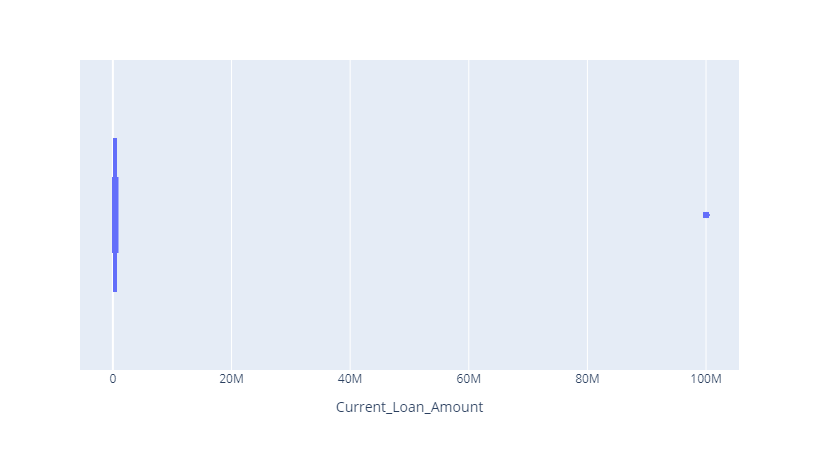

In [26]:
# fig = px.histogram(trainDf, x='Current_Loan_Amount', nbins=50)
fig = px.box(trainDf, x='Current_Loan_Amount')
fig.show()

 - As observed above, "Current_Loan_Amount" is having 870 samples, which are having the values near to 100 Million. We need to find a strategy to handle the outliers based on how much this feature is correlated to the target feature - 'Credit_Default'

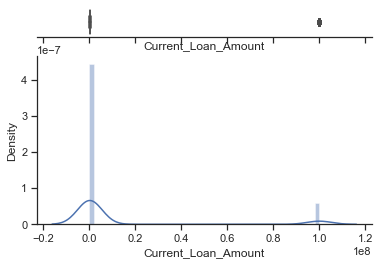

In [27]:
x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(trainDf['Current_Loan_Amount'], ax=ax_box)
sns.distplot(trainDf['Current_Loan_Amount'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

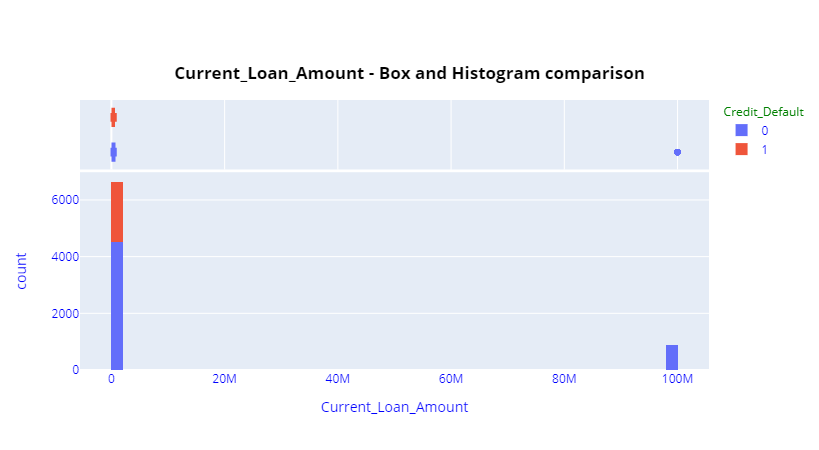

In [77]:
import plotly.express as px
# df = px.data.tips()
df = trainDf
x = 'Current_Loan_Amount'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

fig = px.histogram(df, x=x, color=y,
                   marginal="box", # or violin, rug
                   hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )
fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()